<a href="https://colab.research.google.com/github/kislay960/Healthcare-claim-data-analysis/blob/master/AGBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings

In [38]:
fraud_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train-1542865627584.csv')
bene_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train_Beneficiarydata-1542865627584.csv')
outpatient_tr = pd.read_csv('https://media.githubusercontent.com/media/kislay960/data/master/Train_Outpatientdata-1542865627584.csv')
inpatient_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/data/master/Train_Inpatientdata-1542865627584.csv')

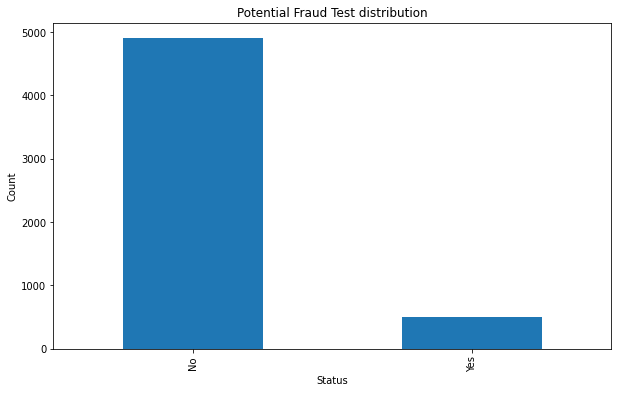

In [39]:

plt.title("Potential Fraud Test distribution")
fraud_tr.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

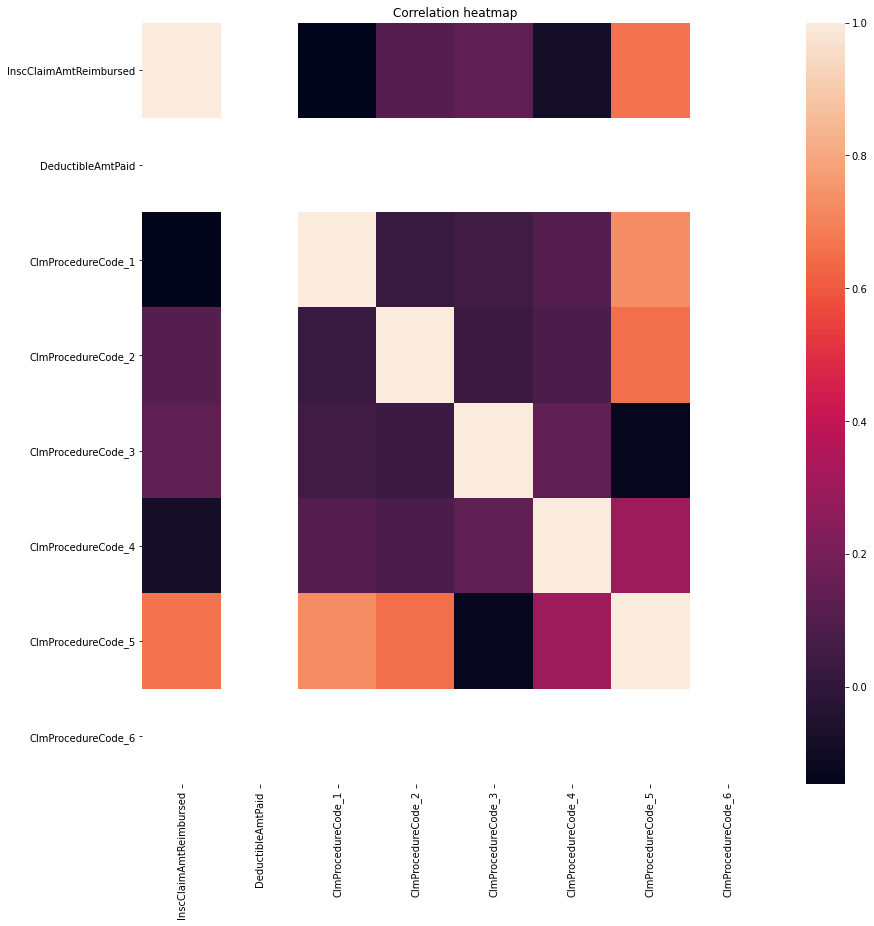

In [40]:
plt.figure(figsize=(14,14))
plt.title('Correlation heatmap')
sns.heatmap(inpatient_tr.corr())
plt.show()

In [41]:
flag=True
df2=pd.DataFrame()
df2=bene_tr[bene_tr['Gender']>2]
df2=bene_tr[bene_tr['Gender']<1]
if df2.shape[0]!=0:
    print("please correct the discrepencies in gender column",df2)
    flag=False

df2=pd.DataFrame()
df2=bene_tr[bene_tr['State']>54]
df2=bene_tr[bene_tr['State']<1]
if df2.shape[0]!=0:
    print("please correct the discrepencies in states column",df2)
    flag=False

df2=pd.DataFrame()
df2=bene_tr[bene_tr['County']>999]
df2=bene_tr[bene_tr['County']<0]
if df2.shape[0]!=0:
    print("please correct the discrepencies in Countries column \n",df2)
    flag=False

df2=pd.DataFrame()
df2=inpatient_tr[inpatient_tr['ClaimID'].duplicated()]
if df2.shape[0]!=0:
    print("please correct the discrepencies in Claimid as multiple peoples have same Claimid: \n",df2)
    flag=False

In [42]:
if flag:
    print("No discrepancies found")

No discrepancies found


In [43]:
bene_tr.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


**TASK 2**

In [44]:
overpmnt = pd.DataFrame([bene_tr.BeneID, bene_tr.IPAnnualReimbursementAmt, bene_tr.IPAnnualDeductibleAmt, bene_tr.OPAnnualReimbursementAmt, bene_tr.OPAnnualDeductibleAmt]).transpose()

In [45]:
overpmnt.head()

,BeneID,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,36000,3204,60,70
1,BENE11002,0,0,30,50
2,BENE11003,0,0,90,40
3,BENE11004,0,0,1810,760
4,BENE11005,0,0,1790,1200


In [46]:
overpmnt['Bill'] = overpmnt['IPAnnualReimbursementAmt'] + overpmnt['OPAnnualReimbursementAmt']
overpmnt['Reimbursement'] = overpmnt['IPAnnualDeductibleAmt'] + overpmnt['OPAnnualDeductibleAmt']

In [47]:
overpmnt.head()

,BeneID,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Bill,Reimbursement
0,BENE11001,36000,3204,60,70,36060,3274
1,BENE11002,0,0,30,50,30,50
2,BENE11003,0,0,90,40,90,40
3,BENE11004,0,0,1810,760,1810,760
4,BENE11005,0,0,1790,1200,1790,1200


In [48]:
overpmnt.drop(overpmnt.columns[[1,2,3,4]], axis=1, inplace=True)
overpmnt.head()

,BeneID,Bill,Reimbursement
0,BENE11001,36060,3274
1,BENE11002,30,50
2,BENE11003,90,40
3,BENE11004,1810,760
4,BENE11005,1790,1200


In [49]:

overpmnt['Overpayment'] = np.where(overpmnt['Bill']>overpmnt['Reimbursement'],True,False)

In [50]:
overpmnt.head()

,BeneID,Bill,Reimbursement,Overpayment
0,BENE11001,36060,3274,True
1,BENE11002,30,50,False
2,BENE11003,90,40,True
3,BENE11004,1810,760,True
4,BENE11005,1790,1200,True


**TASK 3**

In [51]:
In_Provider=pd.DataFrame([inpatient_tr['Provider'].value_counts().index,inpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Inpatient_Claim_Number'},axis=1)
Out_Provider=pd.DataFrame([outpatient_tr['Provider'].value_counts().index,outpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Outpatient_Claim_Number'},axis=1)
provider_claimnumber=pd.merge(In_Provider,Out_Provider,on='Provider',how='outer')
inreimburse_by_provider=inpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
inreimburse_temp1=pd.DataFrame([inreimburse_by_provider.index,inreimburse_by_provider])
inreimburse_temp2=inreimburse_temp1.transpose()
In_Provider_Claim=inreimburse_temp2.rename({0:'Provider',1:'Inpatient_Claim_Amount'},axis=1)
outreimburse_by_provider=outpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
outreimburse_temp=pd.DataFrame([outreimburse_by_provider.index,outreimburse_by_provider]).transpose()
#outreimburse_temp2=outreimburse_temp.transpose()
Out_Provider_Claim=outreimburse_temp.rename({0:'Provider',1:'Outpatient_Claim_Amount'},axis=1)
provider_claimamount=pd.merge(In_Provider_Claim,Out_Provider_Claim,on='Provider',how='outer')
provider_list1=pd.merge(fraud_tr,provider_claimnumber,on='Provider',how='outer')
provider_list2=pd.merge(provider_list1,provider_claimamount,on='Provider',how='outer')

In [52]:
provider_list2

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,NaN,149,NaN,52170
3,PRV51005,Yes,NaN,1165,NaN,280910
4,PRV51007,No,3,69,19000,14710
...,...,...,...,...,...,...
5405,PRV57759,No,NaN,28,NaN,10640
5406,PRV57760,No,NaN,22,NaN,4770
5407,PRV57761,No,NaN,82,NaN,18470
5408,PRV57762,No,NaN,1,NaN,1900


In [53]:
provider_clean=provider_list2.fillna(0)
y = provider_clean['PotentialFraud'].values
X = provider_clean.drop(['PotentialFraud','Provider'], axis=1).values

In [54]:
warnings. filterwarnings('ignore')

In [55]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 93.13429974590714%


**TASK 4**

In [56]:
provider_clean

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,0,149,0,52170
3,PRV51005,Yes,0,1165,0,280910
4,PRV51007,No,3,69,19000,14710
...,...,...,...,...,...,...
5405,PRV57759,No,0,28,0,10640
5406,PRV57760,No,0,22,0,4770
5407,PRV57761,No,0,82,0,18470
5408,PRV57762,No,0,1,0,1900


In [57]:
provider_clean.head()

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,0,149,0,52170
3,PRV51005,Yes,0,1165,0,280910
4,PRV51007,No,3,69,19000,14710


In [58]:
provider_clean['Mode_of_Payment'] = np.where(provider_clean['Inpatient_Claim_Number']<3,'Check','EFT')

In [59]:
provider_clean

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount,Mode_of_Payment
0,PRV51001,No,5,20,97000,7640,EFT
1,PRV51003,Yes,62,70,573000,32670,EFT
2,PRV51004,No,0,149,0,52170,Check
3,PRV51005,Yes,0,1165,0,280910,Check
4,PRV51007,No,3,69,19000,14710,EFT
...,...,...,...,...,...,...,...
5405,PRV57759,No,0,28,0,10640,Check
5406,PRV57760,No,0,22,0,4770,Check
5407,PRV57761,No,0,82,0,18470,Check
5408,PRV57762,No,0,1,0,1900,Check


In [60]:
y = provider_clean['Mode_of_Payment'].values
X = provider_clean.drop(['PotentialFraud','Provider','Mode_of_Payment'], axis=1).values

In [61]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 96.83112410814806%
